# Time Series Analysis Ethereum Prices

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import api as smt
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")

We import the data

In [2]:
ethusd_data_raw = pd.read_csv("./2019-01-01_2020-12-11_ethereumprice_org.csv")
ethusd_data_raw.head()

,timestamp,open,high,low,close
0,1607644800,558.549922,undefined,undefined,undefined
1,1607558400,573.929015,574.8450094838519,549.1802302242935,558.5064466850556
2,1607472000,554.819245,577.7084307652647,531.187178148795,573.3586030033067
3,1607385600,591.130763,591.8160864000191,550.8678023008441,554.7577055601023
4,1607385540,591.384859,undefined,undefined,undefined


## Data Exploration
_________

In [3]:
# Cleaning undefined entries
ethusd_data = ethusd_data_raw[ethusd_data_raw['close'] != "undefined"][['timestamp', 'close']].astype(float)
ethusd_data.sort_values(by='timestamp', ascending=True, inplace=True)

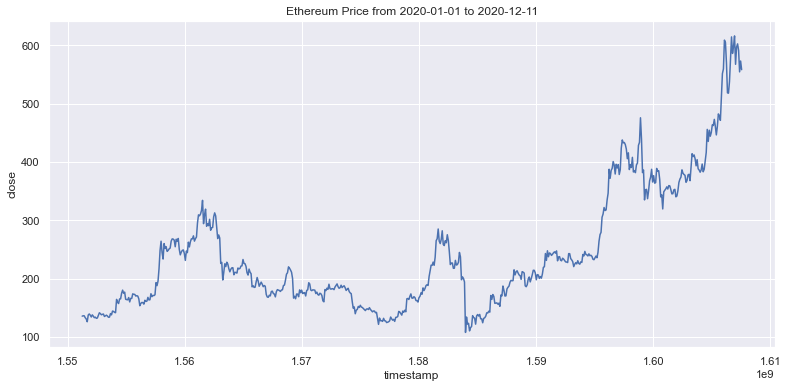

In [4]:
fig, ax = plt.subplots(figsize=(13,6))
ax.set_title("Ethereum Price from 2020-01-01 to 2020-12-11")
sns.lineplot(ax=ax, x="timestamp", y="close",
             data=ethusd_data)
plt.show()

In this graph, we can see the price of Ethereum has had high variation, but an overall uptrend.

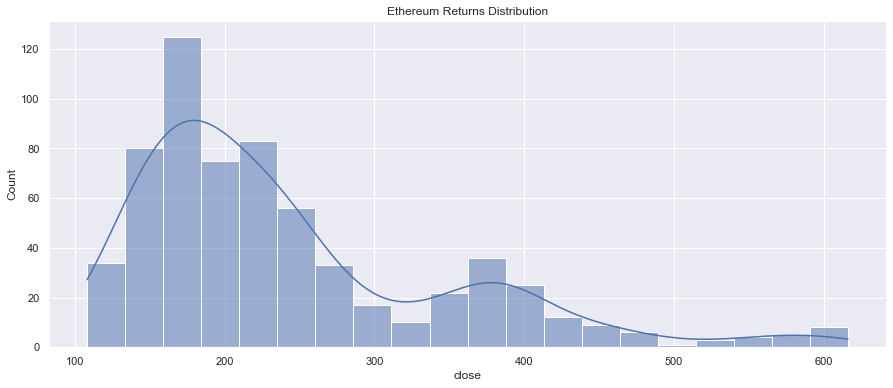

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Ethereum Returns Distribution")
sns.histplot(ax=ax, x='close', data=ethusd_data, kde=True)
plt.show()

The dristribution of closing prices per day over time is right skewed, and so we know there are outliers on the high end of the distribution.

In [25]:
# Normalizing data by identifying returns
ethusd_data['diff1'] = ethusd_data['close'] - ethusd_data['close'].shift(1)
ethusd_data['diff'] = ethusd_data['diff1'] - ethusd_data['diff1'].shift(1)
ethusd_data = pd.concat((ethusd_data['diff'].rolling(7).mean(), ethusd_data), join='inner', axis=1).dropna().reset_index(drop=True)
ethusd_data.columns = ethusd_data.columns = ["diff_ma"] + list(ethusd_data.columns)[1:]

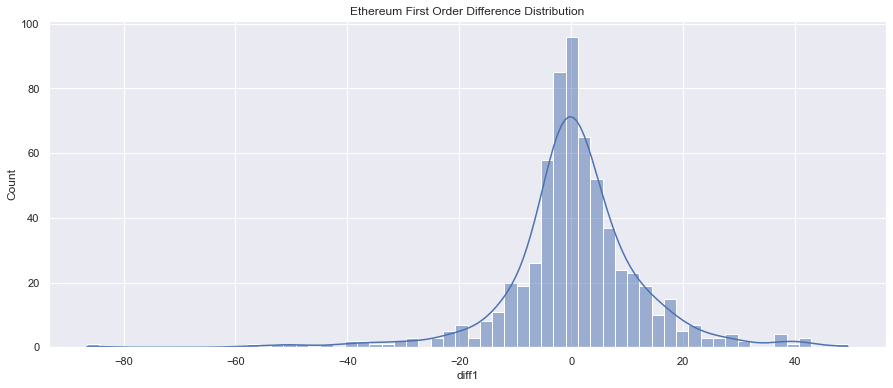

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Ethereum First Order Difference Distribution")
sns.histplot(ax=ax, x='diff1', data=ethusd_data, kde=True)
plt.show()

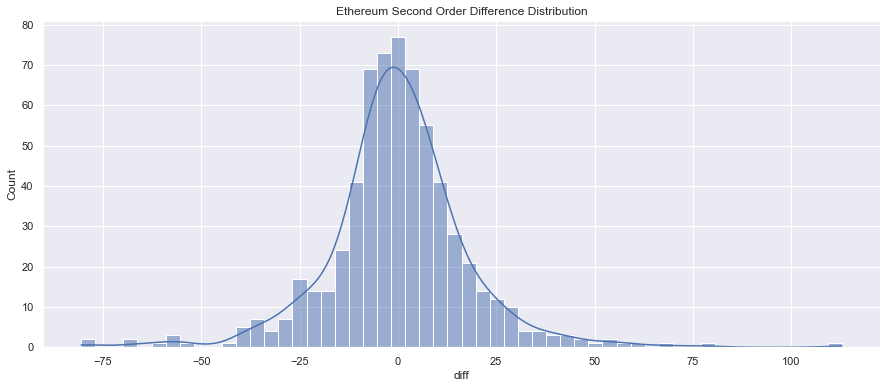

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Ethereum Second Order Difference Distribution")
sns.histplot(ax=ax, x='diff', data=ethusd_data, kde=True)
plt.show()

The second order difference distribution looks perfectly normal

In [8]:
# Summary Statistics
ethusd_data[['close','diff']].describe()

,close,diff
count,644.000000,644.000000
mean,243.356944,-0.025822
std,105.566910,17.924002
min,108.131225,-80.535198
25%,170.457475,-7.589367
50%,211.238398,-0.682171
75%,280.326983,7.735735
max,616.374529,112.909123


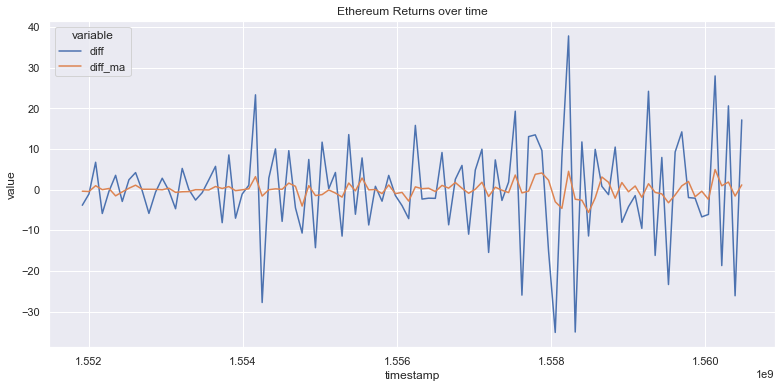

In [9]:
# We do this to condense multiple columns into two (variable and value)
data = pd.melt(ethusd_data[['timestamp','diff','diff_ma']][:100], ['timestamp'])
data['value'] = pd.to_numeric(data['value'])
data['timestamp'] = pd.to_numeric(data['timestamp'])

fig, ax = plt.subplots(figsize=(13,6))
ax.set_title("Ethereum Returns over time")
sns.lineplot(ax=ax, x="timestamp", y="value", hue="variable",
             data=data)
plt.show()

We know, based on observations from the graph, that our price time series is non-stationary. However, we want to test whether the second order difference time series is stationary. This will allow us to continue our analysis of Ethereum prices

In [10]:
print("Dickey-Fuller p: ", adfuller(ethusd_data['close'])[1])

Dickey-Fuller p:  0.8506393361925488


Our Dickey-Fuller test p value for Ethereum prices suggests that our pricing time series is not stationary

In [30]:
print("Dickey-Fuller p: ", adfuller(ethusd_data['diff'])[1])

Dickey-Fuller p:  2.0959246928695642e-14


For our second order difference time series, we have a stationary series

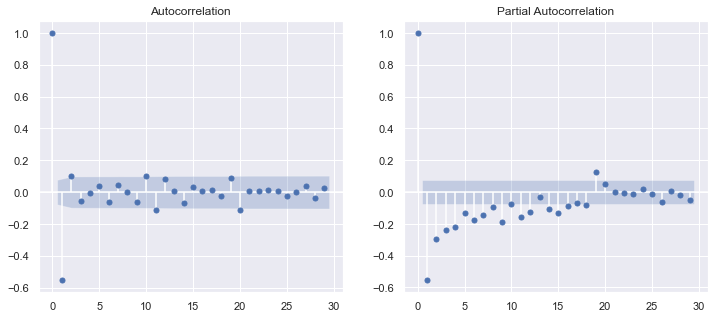

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
smt.graphics.plot_acf(ethusd_data['diff'], ax=ax[0])
smt.graphics.plot_pacf(ethusd_data['diff'], ax=ax[1])
plt.show()

- Autocorrelation - The effect of t-x in t
- Partial Autocorrelation - The exclussive effect of t-x in t


These allow us to identify the orders of our Moving Average and our Auto Regressive models respectively. Both graphs include error bands. Values within the error bands are not statistically significant, and can be interpreted as 0.

- For our Autocorrelation analysis only the first 2 values are beyond our error bands (ignoring our value t - 0)
- For our Partial Autocorrelation analysis we could say our first 12 values lie beyond our error bands

## ARIMA Model

In [13]:
training_data = ethusd_data[:500]

model = ARIMA(training_data['close'], order=(9,2,2)).fit(disp=-1)
fitted_values = model.fittedvalues
ethusd_diff = training_data['close'][:500] - training_data['close'][:500].shift(1)
ethusd_diff = ethusd_diff - ethusd_diff.shift(1)

/Users/ellesse3/.virtualenvs/pymain/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


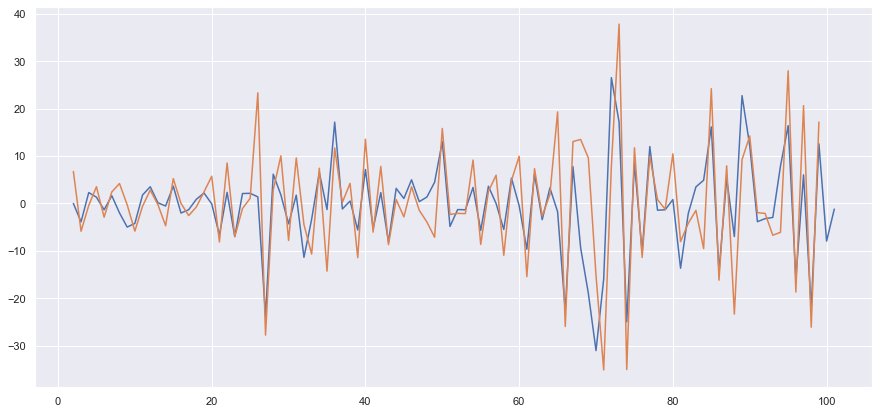

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(fitted_values[:100])
ax.plot(ethusd_diff[:100])
plt.show()

Our model very closely follow the true time series

## Testing our Model
______

To test our model we will use testing data unknown to the model and try to predict the next day movement

In [15]:
test_data = ethusd_data[500:]

To perform our test, train our model for each prediction (over 100 times) so that we are always predicting the next movement with the most recent data.

For x days, we train our model with data of size x and predict x+1, x+2, and x+3

In [16]:
pred = list()

for index, day in test_data.iterrows():
    print(index, ", ", end='')
    train_data = ethusd_data[:index]
    model = ARIMA(train_data['close'], order=(9,2,2)).fit(disp=-1)
    price_hat = model.predict(index, index+3)
    pred.append(price_hat)

500 , /Users/ellesse3/.virtualenvs/pymain/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
501 , 502 , 503 , 504 , 505 , 506 , 507 , 508 , 509 , 510 , 511 , 512 , 513 , 514 , 515 , 516 , 517 , 518 , 519 , 520 , 521 , 522 , 523 , 524 , 525 , 526 , 527 , 528 , 529 , 530 , 531 , 532 , 533 , 534 , 535 , 536 , 537 , 538 , 539 , 540 , 541 , 542 , 543 , 544 , 545 , 546 , 547 , 548 , 549 , 550 , 551 , 552 , 553 , 554 , 555 , 556 , 557 , 558 , /Users/ellesse3/.virtualenvs/pymain/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
559 , 560 , 561 , 562 , 563 , 564 , 565 , 566 , 567 , 568 , 569 , 570 , 571 , 572 , 573 , 574 , 575 , 576 , 577 , 578 , 579 , 580 , 581 , 582 , 583 , 584 , 585 

In [17]:
# We get rid of the last 2 predictions (we do not have enough data to validate)
phat_one = np.array([p.iloc[0] for p in pred])[:-2]

In [18]:
def get_difference(order, series):
    """
    Get the x order difference of a series
    """
    differences = series.copy()
    for i in range(order):
        differences = differences[1:] - differences[:-1]
    return differences


def invert_difference(order, differences, original):
    """
    Given an original series and a series of differences of x order, recreate the 
    original series using the provided differences.
    """
    if order <= 1:
        return np.array([original[0]] + list(original[:-1] + differences))
    else:
        calc_differences = get_difference(order-1, original)
        calc_differences = np.array([calc_differences[0]] + list(calc_differences[:-1] + differences))
        return invert_difference(order-1, calc_differences, original)

Let's calculate the Mean Squared Error for our predictions

In [19]:
print("Root Mean Squared Error: ",
    math.sqrt(
        ((get_difference(1, np.array(test_data['close'])) 
        - invert_difference(1, np.array(phat_one), get_difference(1, np.array(test_data['close'])))
        )**2).mean()
    )
)

Root Mean Squared Error:  32.62655182431753


This means that we are wrong by an average of $32 dollars in our predictions. Let's go ahead and visualize this to get a better understanding of what is happening.

### Visualizing Predictions
-

In the next 3 graphs we can visualize the predictions created by our model.
- The first graph is our second order difference prediction - The direct output of our model
- The second graph is our first order difference prediction - Our prediction of the changes in price per day
- The third graph shows the price prediction directly

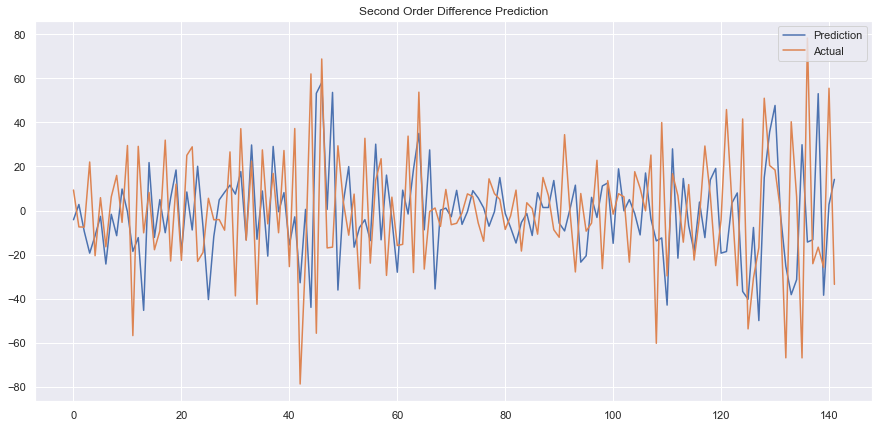

In [34]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Second Order Difference Prediction")
ax.plot(phat_one, label="Prediction")
ax.plot(get_difference(2, np.array(test_data['close'])), label="Actual")
plt.legend(loc="upper right")
plt.show()

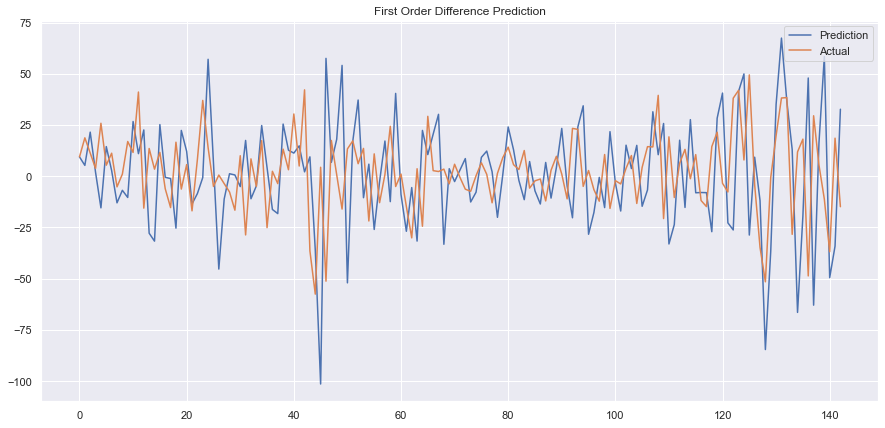

In [35]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("First Order Difference Prediction")
ax.plot(invert_difference(1, np.array(phat_one), get_difference(1, np.array(test_data['close']))), label="Prediction")
ax.plot(get_difference(1, np.array(test_data['close'])), label="Actual")
plt.legend(loc="upper right")
plt.show()

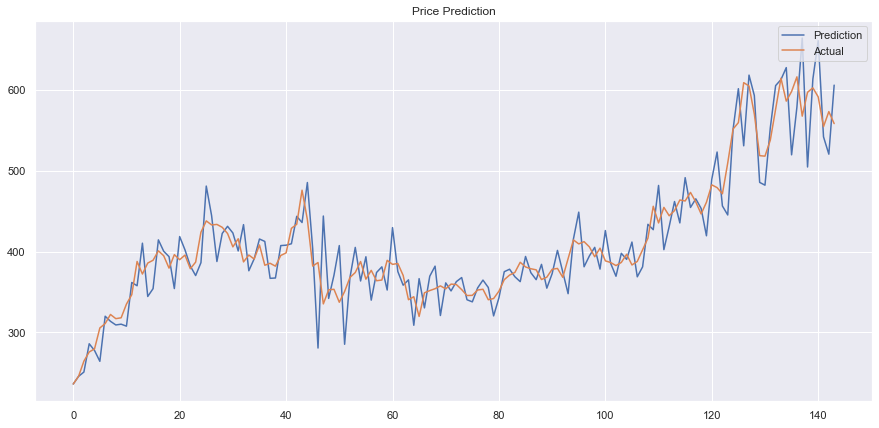

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Price Prediction")
ax.plot(invert_difference(2, np.array(phat_one), np.array(test_data['close'])), label="Prediction")
ax.plot(np.array(test_data['close']), label="Actual")
plt.legend(loc="upper right")
plt.show()

Based on the previous visualizations, we can see that our model is able to predict price changes for Ethereum USD (moderately). Our model is, however, very volatile and typically lagged as is expected for an ARIMA model. 